## Results of CutMix Augmentation

#### Install Libraries and Packages

In [1]:
import os
import re
import pandas as pd
from glob import glob
from pathlib import Path
from collections import Counter 
import numpy as np
import torchvision
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

pd.set_option('display.max_rows', 500)

#### Load the Data

In [47]:
search_path = "../model_results"
file_extension = "*.csv"

# Retrieve results from github directory
dfs = []
[dfs.append(pd.read_csv(file, index_col=0))
 for path, subdir, files in os.walk(search_path)
 for file in glob(os.path.join(path, file_extension))]

# Convert the accuracy scores to percentages.
df = pd.concat(dfs, ignore_index=True)
df['Accuracy'] = df['Accuracy'].apply(lambda x: x*100)

# Filter the results to focus on cutmix trained models.
# df_dnet = df[df["Model"].str.contains('_cm_')]

# Get accuracy score of last epoch for each model type
df = df[df.groupby(['Model'])['Epoch'].transform(max) == df['Epoch']]

# Remove models that we did not run randaugment datasets through
df = df[~df["Model"].str.contains('resnet_basic_44')]
df = df[~df["Model"].str.contains('pyramidnet_basic_110_84')]
df = df[~df["Model"].str.contains('resnext_29_8x64d')]

df['cm'] = df['Model'].str.contains("_cm_")
df['ra'] = df['Model'].str.contains("ra_")
df['val'] = df['Model'].str.contains("_c10val")
df['refined'] = df['Model'].str.contains("refined400")

def ra_N_extraction(row):
    p3 = re.compile("ra_(\d+)_(\d+)")
    N=0 
    if row['ra'] == True :
        srch3 = p3.search(row['Model'].lower())
        N = int(srch3.group(1))
    return N

def ra_M_extraction(row):
    p3 = re.compile("ra_(\d+)_(\d+)")
    M=0 
    if row['ra'] == True :
        srch3 = p3.search(row['Model'].lower())
        M = int(srch3.group(2))
    return M

def cm_Alpha_extraction(row):
    p4 = re.compile("cm_(\d+)_([\.\d]+)")
    alpha = 0
    if row['cm'] == True :
        srch4 = p4.search(row['Model'].lower())
        alpha = float(srch4.group(2))
    return alpha
    

def chart_name(row):
    newname = row.Model.split('_')[0]
    #if row[(row['cm'] == False) and (row['ra'] == False)]:
    
    if row["cm"] == False:
        pass
    else:
        if row['refined'] == True :
            newname += " Train: CutMix Alpha=" + str(row['Alpha']) + " + Unaugmented Refine" 
        else:
            newname += " Train: CutMix Alpha=" + str(row['Alpha'])
     
    return newname
    
df['N'] = df.apply(lambda row: ra_N_extraction(row), axis=1)
df['M'] = df.apply(lambda row: ra_M_extraction(row), axis=1)
df['Alpha'] = df.apply(lambda row: cm_Alpha_extraction(row), axis=1)
df['ChartName'] = df.apply(lambda row: chart_name(row), axis=1)
#cols = ['Alpha']
#df['hue'] = df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

df['hue'] = df['Model'].apply(lambda row: row.split('_')[0])

# Reduce the dataset to focus on CutMix Results
df = df[df.ra == False]

# Filter columns to those we need for analysis
df2 = df
df = df[['Model', 'Accuracy', 'Loss', 'Testset', 'cm', 'ra', 'val', 'refined', 'N', 'M', 'Alpha', 'ChartName', 'hue']].sort_values(by=['Model'])
df.head()

,Model,Accuracy,Loss,Testset,cm,ra,val,refined,N,M,Alpha,ChartName,hue
43,densenet_BC_100_12,94.84,0.2223,cifar10,False,False,False,False,0,0,0.0,densenet,densenet
44,densenet_BC_100_12,88.30,0.5098,cifar10.1,False,False,False,False,0,0,0.0,densenet,densenet
45,densenet_BC_100_12_cm_1_.5,30.93,3.0530,cifar10,True,False,False,False,0,0,0.5,densenet Train: CutMix Alpha=0.5,densenet
46,densenet_BC_100_12_cm_1_.5,27.10,3.2110,cifar10.1,True,False,False,False,0,0,0.5,densenet Train: CutMix Alpha=0.5,densenet
47,densenet_BC_100_12_cm_1_.5_refined400,86.30,0.7471,cifar10.1,True,False,False,True,0,0,0.5,densenet Train: CutMix Alpha=0.5 + Unaugmented...,densenet


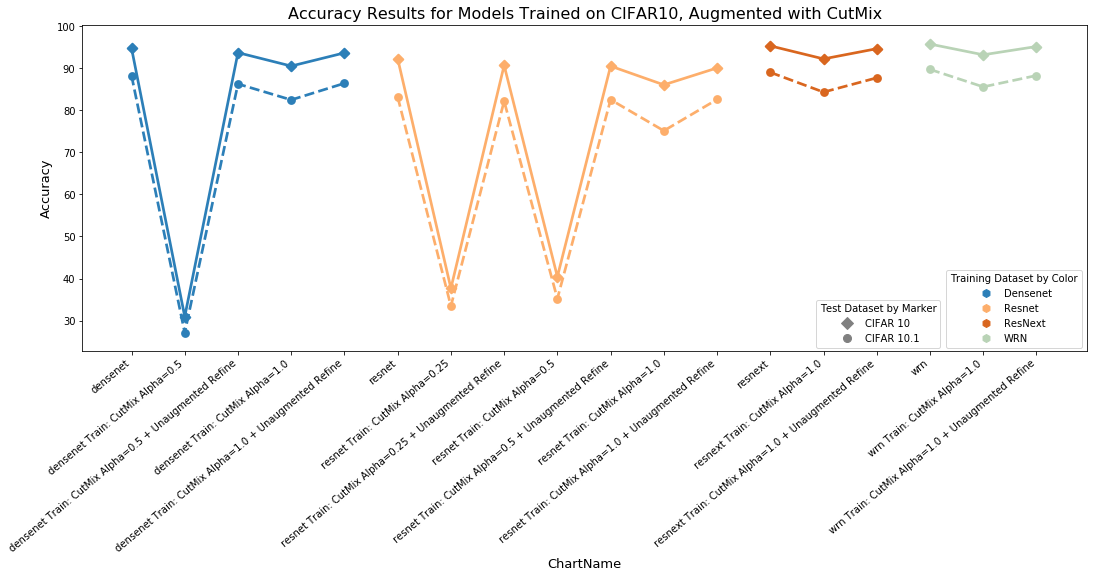

In [48]:
flatui = ["#2c7fb8", "#fdae6b", "#D9661F", "#B9D3B6", "#B9D3B6", "#859438"]

f, ax = plt.subplots(figsize=(18, 6))
sp = sns.pointplot(x="ChartName", hue="hue", y="Accuracy", data=df[df['Testset'] == 'cifar10'], 
                   markers=['D'] * 4, linestyles=['-']*4, palette=flatui, ci=None)  
plt.xlabel('Validation Data Type', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.title('Accuracy Results for Models Trained on CIFAR10, Augmented with CutMix', fontsize=16)
plt.setp(ax.get_xticklabels(), rotation=40, horizontalalignment='right')
sns.set_style()

sp = sns.pointplot(x="ChartName", hue="hue", y="Accuracy", data=df[df['Testset'] == 'cifar10.1'], 
                   markers=['o']*4, linestyles=['--']*4, palette=flatui, ci=None,alpha=0.7) # and slightly transparent

train_datasets = ['Densenet', 'Resnet', 'ResNext', 'WRN']
test_datasets = ['CIFAR 10', 'CIFAR 10.1']

h = [plt.plot([],[], color=c, marker="h", ms=8, ls="")[0] for i,c in zip(train_datasets, flatui)]
leg = ax.legend(handles=h, labels=train_datasets,loc=(.86,.01), title="Training Dataset by Color")
ax.add_artist(leg)

h2 = [plt.plot([],[], color='grey', marker=m, ms=8, ls="")[0] for i,m in zip(test_datasets, ['D', 'o'])]
ax.legend(handles=h2, labels=test_datasets,loc=(.73,0.01), title="Test Dataset by Marker")

pass

### Delta 

In [64]:
def orig_acc(row):
    ret_val = row['Original_Accuracy']
    if pd.isnull(row['Original_Accuracy']):
        ret_val = row['Original_Accuracy_300epochs']
    return ret_val


df2['Original_Accuracy'] = df2.apply(lambda row: orig_acc(row), axis=1)
df3 = df2[['Model', 'Accuracy', 'Testset', 'cm', 'Original_Accuracy', 'refined', 'Alpha', 'ChartName']]

df_gp2 = df3.sort_values(by=['Model', 'Testset'])
df3["Observed_Delta"] = df_gp2.groupby(['Model'])['Accuracy'].diff()
df3["Orig_Delta"] = df_gp2.groupby(['Model'])['Original_Accuracy'].diff()

df4 = df3.dropna()
df4 = df4[['Model', 'Observed_Delta', 'Orig_Delta', 'Accuracy']]
df4['SmallerGap'] = df4['Observed_Delta'] > df4['Orig_Delta']
df4['GapDelta'] = np.abs(df4['Orig_Delta']) - np.abs(df4['Observed_Delta'])
df4

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Model,Observed_Delta,Orig_Delta,Accuracy,SmallerGap,GapDelta
34,wrn_28_10_cm_1_1,-7.63,-6.2,85.60,False,-1.43
35,wrn_28_10_cm_1_1_refined400,-6.90,-6.2,88.30,False,-0.70
44,densenet_BC_100_12,-6.54,-7.9,88.30,True,1.36
46,densenet_BC_100_12_cm_1_.5,-3.83,-7.9,27.10,True,4.07
47,densenet_BC_100_12_cm_1_.5_refined400,-7.44,-7.9,86.30,True,0.46
54,resnext_29_4x64d_cm_1_1,-7.90,-6.8,84.35,False,-1.10
55,resnext_29_4x64d_cm_1_1_refined400,-6.93,-6.8,87.75,False,-0.13
66,densenet_BC_100_12_cm_1_1,-8.05,-7.9,82.50,False,-0.15
67,densenet_BC_100_12_cm_1_1_refined400,-7.24,-7.9,86.45,True,0.66
83,wrn_28_10,-6.03,-6.2,89.75,True,0.17
